# Mid Term Part (2): Individual Assignment: Tornado Diagrams and Bidding

By: Chengyi (Jeff) Chen

In [1]:
%load_ext autotime
%load_ext nb_black
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Graphing
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting Design Configs
sns.set(
    font="Verdana",
    rc={
        "axes.axisbelow": False,
        "axes.edgecolor": "lightgrey",
        "axes.facecolor": "None",
        "axes.grid": True,
        "grid.color": "lightgrey",
        "axes.labelcolor": "dimgrey",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "figure.facecolor": "white",
        "lines.solid_capstyle": "round",
        "patch.edgecolor": "w",
        "patch.force_edgecolor": True,
        "text.color": "dimgrey",
        "xtick.bottom": False,
        "xtick.color": "dimgrey",
        "xtick.direction": "out",
        "xtick.top": False,
        "ytick.color": "dimgrey",
        "ytick.direction": "out",
        "ytick.left": False,
        "ytick.right": False,
        "figure.dpi": 100,
        "figure.figsize": (8, 6),
    },
)
sns.set_context(
    "notebook", rc={"font.size": 10, "axes.titlesize": 12, "axes.labelsize": 10}
)
sns.color_palette(palette="Spectral")

# General
import numpy as np
import scipy.stats as sp
import pandas as pd
from functools import partial

# Ignore warnings LOL
import warnings

warnings.simplefilter("ignore")

time: 1.22 s (started: 2021-04-02 15:44:56 +08:00)


<IPython.core.display.Javascript object>

In [2]:
def ρ(γ):
    """Risk tolerance"""
    return 1 / γ

time: 302 µs (started: 2021-04-02 15:44:57 +08:00)


<IPython.core.display.Javascript object>

In [3]:
def r(γ):
    """Risk Odds"""
    return np.log(γ)

time: 414 µs (started: 2021-04-02 15:44:57 +08:00)


<IPython.core.display.Javascript object>

In [4]:
def u(x, γ: np.array = np.array([0.0]), a: float = 0.0, b: float = 1.0):
    """Assuming user satisifies the Δ property, 
    calculates the U-values using either a 
    Piecewise Linear u = a + bx if γ = 0 (Risk-Neutral) 
    else Exponential u = a + be^(-xγ) U-curve U(x)
    
    Args:
        x (np.array): Payoffs of prospects matrix, Shape = (Number of deals, Number of prospects in each deal)
        γ (np.array): Risk-aversion coefficients, Shape = (Number of different risk-aversion coefficients for sensitivity analysis), Default = 0.0 (Risk-neutral) [γ > 0: Risk-averse, γ < 0: Risk-seeking]
        a (float): Constant for U-curve
        b (float): Coefficient for payoff variable
        
    Returns:
        np.array:
            U-values, Shape = (Number of Risk Aversion Coefficients γ, Number of deals, Number of prospects in each deal)
    """
    assert (
        x.ndim == 2
    ), "Payoffs require 2 dimensions, first dim is number of deals, second is number of prospects in each deal."
    γ = np.array([γ]) if np.isscalar(γ) else np.array(γ)
    return np.array(
        [
            np.apply_along_axis(
                func1d=lambda x, γ=γ: a + b * x if γ == 0 else a + b * np.exp(-x * γ),
                axis=-1,
                arr=x,
                γ=γ_i,
            )
            for γ_i in γ
        ]
    )

time: 627 µs (started: 2021-04-02 15:44:57 +08:00)


<IPython.core.display.Javascript object>

In [5]:
def eu(u, p):
    """Assuming user satisifies the Δ property, calculates the 
    hadamard product of the u values matrix and probabilities 
    matrix (respective probabilities associated with each 
    prospect in the u matrix)
    
    Args:
        u (np.array): U-values matrix, Shape = (Number of Risk Aversion Coefficients γ, Number of deals, Number of prospects in each deal)
        p (np.array): Probabilities of each prospect matrix, Shape = (Number of Risk Aversion Coefficients γ, Number of deals, Number of prospects in each deal)
        
    Returns:
        np.array:
            E-values, Shape = (Number of Risk Aversion Coefficients γ, Number of deals) 
    """
    assert (
        u.shape == p.shape
    ), "U-values matrix must be the same shape as the probabilities matrix."

    assert (
        u.ndim == 3
    ), "Both matrices must have 3 dimensions, Shape = (Number of Risk Aversion Coefficients γ, Number of deals, Number of prospects in each deal)."

    return np.sum(u * p, axis=-1)

time: 545 µs (started: 2021-04-02 15:44:57 +08:00)


<IPython.core.display.Javascript object>

In [6]:
def u_inv(eu, γ: np.array = np.array([0.0]), a: float = 0, b: float = 1):
    """Piecewise Inverse of Linear if γ = 0 (Risk-Neutral) 
    else Inverse of Exponential U-curve Certain equivalent 
    function U^{-1}(x)
    
    Args:
        eu (np.array): E[U-Values] / Expectation over u-values, AKA E-values, Shape = (Number of Risk Aversion Coefficients γ, Number of deals)
        γ (np.array): Risk-aversion coefficients, Shape = (Number of different risk-aversion coefficients for sensitivity analysis), Default = 0.0 (Risk-neutral) [γ > 0: Risk-averse, γ < 0: Risk-seeking]
        a (float): Constant for U-curve
        b (float): Coefficient for payoff variable
        
    Returns:
        np.array:
             Certainty Equivalent values, Shape = (Number of Risk Aversion Coefficients γ, Number of deals)
    """
    γ = np.array([γ]) if np.isscalar(γ) else np.array(γ)

    for eu_i, γ_i in zip(eu, γ):
        if not np.isclose(γ_i, 0):
            assert np.alltrue(
                eu_i > 0
            ), "E[U-Values] / Expectation over u-values must be positive for γ > 0 and γ < 0 in order for inverse of Exponential U-curve to work."

    assert (
        eu.shape[0] == γ.shape[0]
    ), "E-values first dimension must be the same as γ first dimension for inverse operation."

    return np.array(
        [
            list(
                map(
                    lambda eu, γ=γ_i: (eu - a) / b if γ == 0 else -(1 / γ) * np.log(eu),
                    eu_i,
                )
            )
            for eu_i, γ_i in zip(eu, γ)
        ]
    )

time: 839 µs (started: 2021-04-02 15:44:57 +08:00)


<IPython.core.display.Javascript object>

In [7]:
def certainty_equivalent_values_calculator(
    u,
    u_inv,
    x: np.array = None,
    p: np.array = None,
    N: int = 10,
    payout_lb: float = 0.0,
    payout_ub: float = 100.0,
    γ: np.array = np.array([0.0]),
):
    """Assuming user satisifies the Δ property, calculates the Certainty Equivalent values for a given 
    payoff matrix `x` and probability matrix `p`. If both matrices
    are not provided, random matrices will be sampled to simulate
    calculations.

    Args:
        u (function): U-curve function
        u_inv (function): Inverse U-curve function
        x (np.array): Payoffs of prospects matrix, Shape = (Number of deals, Number of prospects in each deal)
        p (np.array): Probabilities of each prospect matrix, Shape = (Number of deals, Number of prospects in each deal)
        N (int): Number of prospects
        payout_lb (float): Lower Bound of Payout for simulation, Default = 0.0
        payout_ub (float): Upper Bound of Payout for simulation, Default = 100.0
        γ (np.array): Risk-aversion coefficients, Shape = (Number of different risk-aversion coefficients for sensitivity analysis), Default = 0.0 (Risk-neutral) [γ > 0: Risk-averse, γ < 0: Risk-seeking]
        
    Returns:
        np.array:
            Certainty Equivalent values, Shape = (Number of Risk Aversion Coefficients γ, Number of deals)
    """
    γ = np.array([γ]) if np.isscalar(γ) else np.array(γ)

    # Case 1: Simulator - Both x and p arent provided
    if p is None and x is None:

        # Preferential probabilities for each prospect
        p = np.random.dirichlet(np.ones(N), size=1)

        # Payouts for each prospect
        x = np.expand_dims(np.random.randint(payout_lb, payout_ub, size=N), axis=0)

    # Case 2: Simulator - Only payouts provided
    elif p is None:

        # Payouts for each prospect
        x = np.expand_dims(
            np.random.randint(payout_lb, payout_ub, size=p.shape[-1]), axis=0
        )

    # Case 3: Simulator - Only probabilities provided
    elif x is None:

        # Preferential probabilities for each prospect
        p = np.random.dirichlet(np.ones(x.shape[-1]), size=1)

    # Case 4: Calculator - Both are provided
    else:

        pass

    # Check that payoffs and probability assignments are the same shape
    assert (
        x.shape == p.shape
    ), "Payoffs `x` and Probabilities `p` must be the same shape=(Number of deals, Number of prospects in each deal)."

    # Calculates U-values Shape = (Number of Risk Aversion Coefficients γ, Number of deals, Number of prospects in each deal)
    u_values = u(x, γ=γ)

    # Reshape p to match U-values shape
    p_reshaped = np.array([p for _ in range(u_values.shape[0])])

    # Expectation of U values Shape = (Number of Risk Aversion Coefficients γ, Number of deals)
    eu_values = eu(u=u_values, p=p_reshaped)

    # Certainty equivalent value of deal
    ce_values = u_inv(eu_values, γ=γ)

    return ce_values

time: 1.23 ms (started: 2021-04-02 15:44:57 +08:00)


<IPython.core.display.Javascript object>

---
## 1) Tornado Diagrams: The Clairvoyant goes to College

Flicks Inc is a major entertainment corporation. They have just produced a major motion picture called The Clairvoyant goes to College. They have spent some money on the movie and they believe their future profit is calculated as

\begin{align}
    \text{Profit} &= \left(0.2\times \text{Number of people} \times \text{Ticket price}\right) - \text{Distribution cost} \\
\end{align}

They provide the following 10-50-90 assessments for three uncertainties. (Distribution cost and Number people seeing movie is in millions of $\$ $ while ticket price is in $\$ $)

 ```{list-table}
:header-rows: 1

* -
  - 10%
  - 50%
  - 90%
* - Number of people (Millions)
  - 11.33
  - 76
  - 140.66
* - Ticket Price
  - $ \$ 7.00 $
  - $ \$ 7.50 $
  - $ \$ 7.75 $
* - Distribution cost (Millions)
  - $ \$ 67.00 $
  - $ \$ 80.00 $
  - $ \$ 86.00 $
```

Draw the tornado diagram and show all tables used in the calculations.

In [8]:
clairvoyant_goes_to_college_uncertainties = pd.DataFrame(
    data=[[11.33, 76.0, 140.66], [7.0, 7.5, 7.75], [67.0, 80.0, 86.0]],
    index=[
        "Number of people (Millions)",
        "Ticket Price",
        "Distribution cost (Millions)",
    ],
    columns=["10%", "50%", "90%"],
)
clairvoyant_goes_to_college_uncertainties

,10%,50%,90%
Number of people (Millions),11.33,76.0,140.66
Ticket Price,7.00,7.5,7.75
Distribution cost (Millions),67.00,80.0,86.00


time: 10.3 ms (started: 2021-04-02 15:44:57 +08:00)


<IPython.core.display.Javascript object>

In [9]:
# Profit Formula (Millions)
profit = lambda n_ppl, ticket_px, dist_cost: (0.2 * n_ppl * ticket_px) - dist_cost

time: 370 µs (started: 2021-04-02 15:44:57 +08:00)


<IPython.core.display.Javascript object>

In [10]:
# Get the Profit, fixing entries and using baseline (50%) values as other parameters
npv = clairvoyant_goes_to_college_uncertainties.copy()
for row in clairvoyant_goes_to_college_uncertainties.index:
    for col in clairvoyant_goes_to_college_uncertainties.columns:
        profit_params = clairvoyant_goes_to_college_uncertainties["50%"].copy()
        profit_params[row] = clairvoyant_goes_to_college_uncertainties[col][row]
        npv[col][row] = profit(*profit_params)

npv

,10%,50%,90%
Number of people (Millions),-63.005,34.0,130.99
Ticket Price,26.400,34.0,37.80
Distribution cost (Millions),47.000,34.0,28.00


time: 10.1 ms (started: 2021-04-02 15:44:57 +08:00)


<IPython.core.display.Javascript object>

In [11]:
# Max Swing
max_swing = npv.max(axis=1) - npv.min(axis=1)
max_swing

Number of people (Millions)     193.995
Ticket Price                     11.400
Distribution cost (Millions)     19.000
dtype: float64

time: 6.65 ms (started: 2021-04-02 15:44:57 +08:00)


<IPython.core.display.Javascript object>

In [12]:
# Max Swing Squared
max_swing_squared = max_swing ** 2
max_swing_squared

Number of people (Millions)     37634.060025
Ticket Price                      129.960000
Distribution cost (Millions)      361.000000
dtype: float64

time: 2.8 ms (started: 2021-04-02 15:44:57 +08:00)


<IPython.core.display.Javascript object>

In [13]:
# Normalized Max Swing Squared
norm_max_swing_squared = max_swing_squared / sum(max_swing_squared)
norm_max_swing_squared

Number of people (Millions)     0.987122
Ticket Price                    0.003409
Distribution cost (Millions)    0.009469
dtype: float64

time: 3.32 ms (started: 2021-04-02 15:44:57 +08:00)


<IPython.core.display.Javascript object>

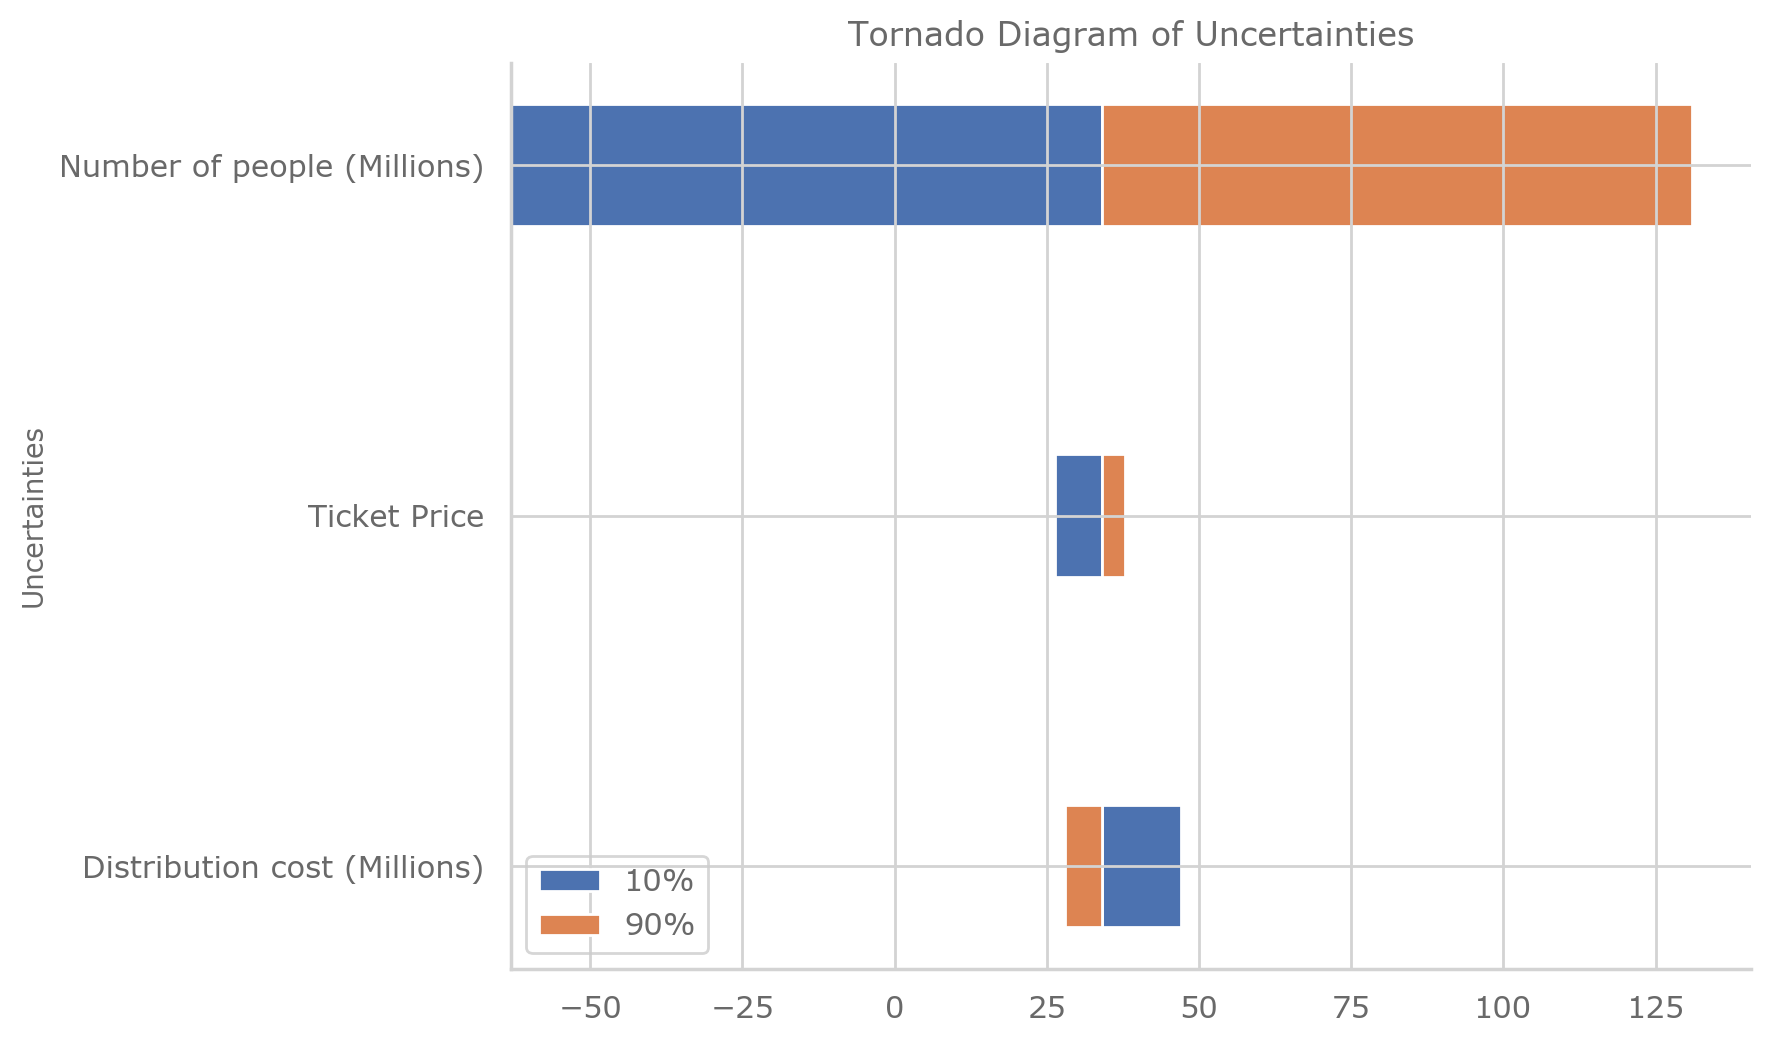

time: 311 ms (started: 2021-04-02 15:44:57 +08:00)


<IPython.core.display.Javascript object>

In [14]:
# Tornado diagram
npv = npv.reindex(norm_max_swing_squared.index[::-1])

fig, ax = plt.subplots()

ax.barh(
    npv.index,
    npv["50%"].values - npv["10%"].values,
    0.35,
    align="center",
    label="10%",
    left=npv["10%"].values,
)
ax.barh(
    npv.index,
    npv["90%"].values - npv["50%"].values,
    0.35,
    align="center",
    label="90%",
    left=npv["50%"].values,
)

ax.set_ylabel("Uncertainties")
ax.set_title("Tornado Diagram of Uncertainties")
ax.legend()

plt.show()

---
## 2) Optimal Bidding

Determine the optimal bid for a decision maker with an exponential $u$-function with a risk aversion coefficient, $\gamma = 0.001$, a maximum competitive bid distribution, as a scaled Beta distribution, $Beta\left(\alpha=10, \beta=10, \text{loc}=0, \text{scale}=1000\right)$, and PIBP for the bidding item is $ \$ 900$. 

1)	Plot the Opposing forces of bidding (i.e. plot the CDF and the curve of [PIBP-bid])

In [15]:
pibp = 900
γ = 0.001
bids = np.array(list(range(900 + 1)))
pibp_net = pibp - bids
p_acquire = np.array([sp.beta.cdf(x=rv, a=10, b=10, loc=0, scale=1000) for rv in bids])

time: 202 ms (started: 2021-04-02 15:44:58 +08:00)


<IPython.core.display.Javascript object>

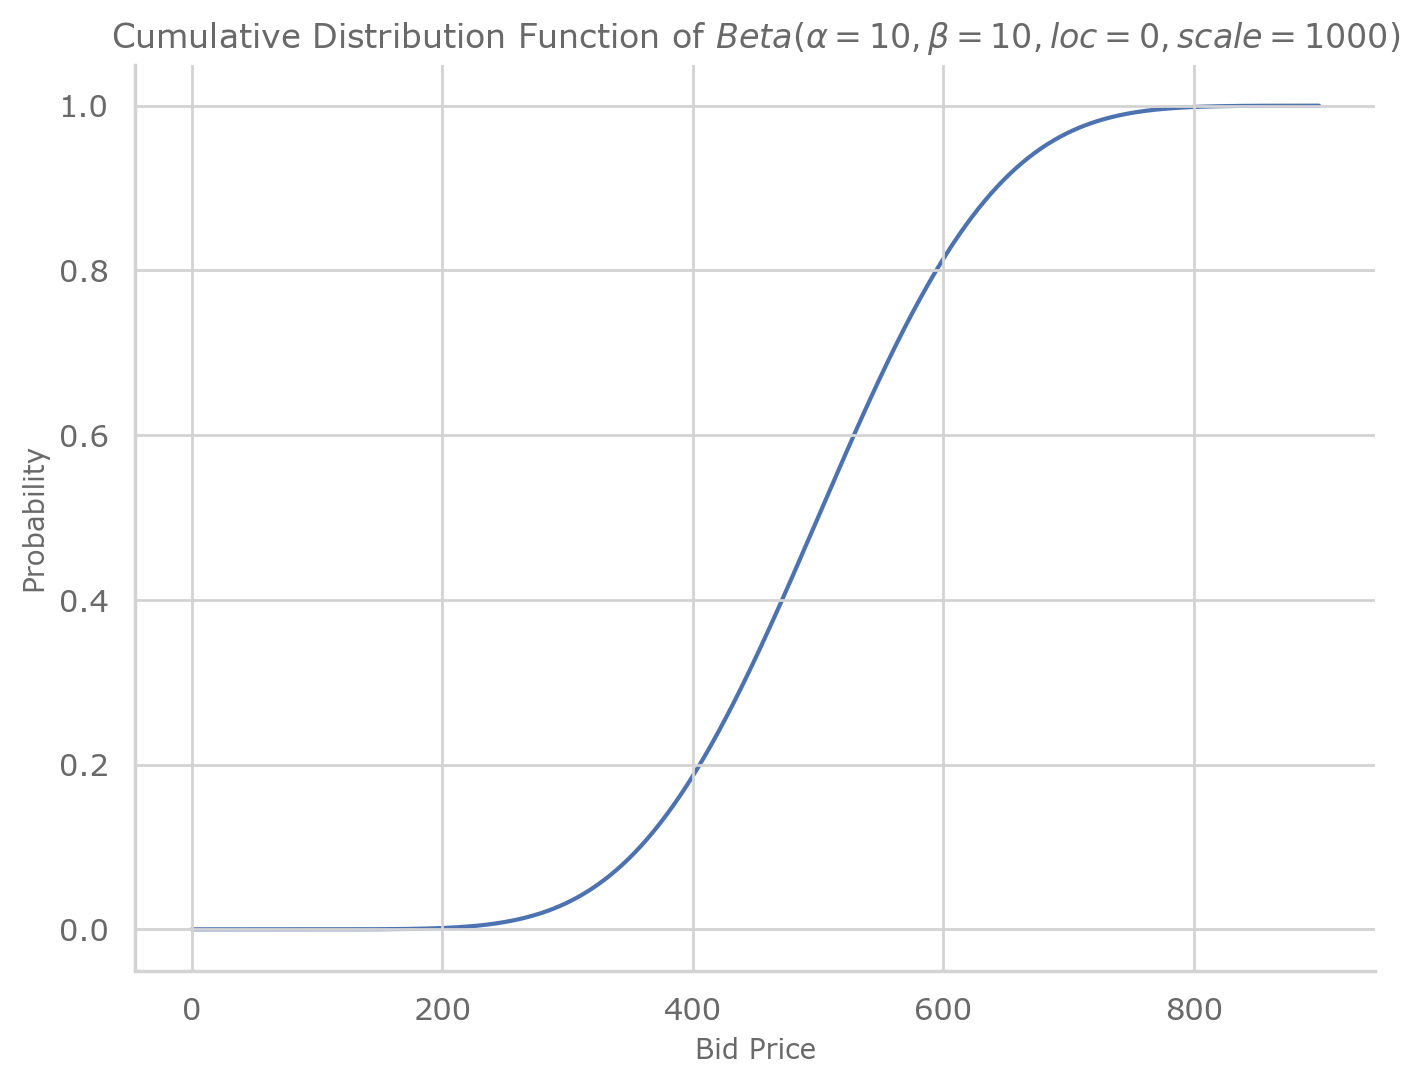

time: 483 ms (started: 2021-04-02 15:44:58 +08:00)


<IPython.core.display.Javascript object>

In [16]:
fig, ax = plt.subplots(1, 1)

ax.plot(bids, p_acquire)
ax.set_xlabel("Bid Price")
ax.set_ylabel("Probability")
ax.set_title(
    r"Cumulative Distribution Function of $Beta \left(\alpha=10, \beta=10, loc=0, scale=1000 \right)$"
)
plt.show()

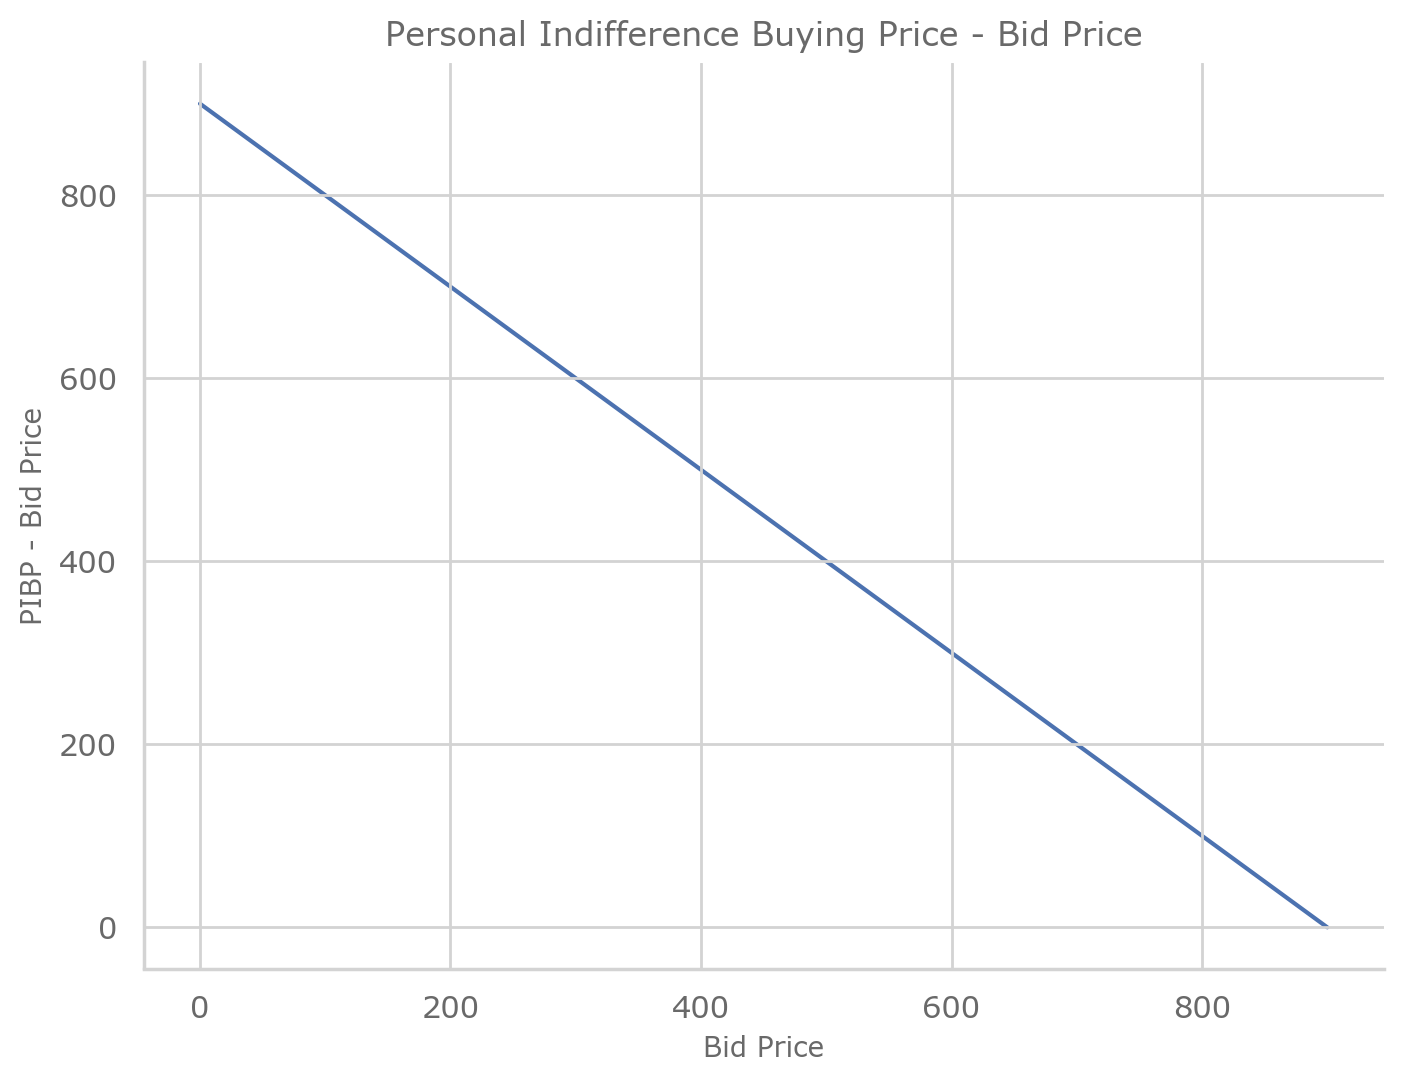

time: 271 ms (started: 2021-04-02 15:44:58 +08:00)


<IPython.core.display.Javascript object>

In [17]:
fig, ax = plt.subplots(1, 1)

ax.plot(bids, pibp_net)
ax.set_xlabel("Bid Price")
ax.set_ylabel("PIBP - Bid Price")
ax.set_title(r"Personal Indifference Buying Price - Bid Price")
plt.show()

2)	Plot the value of the auction situation (certain equivalent) vs the bid amount.  

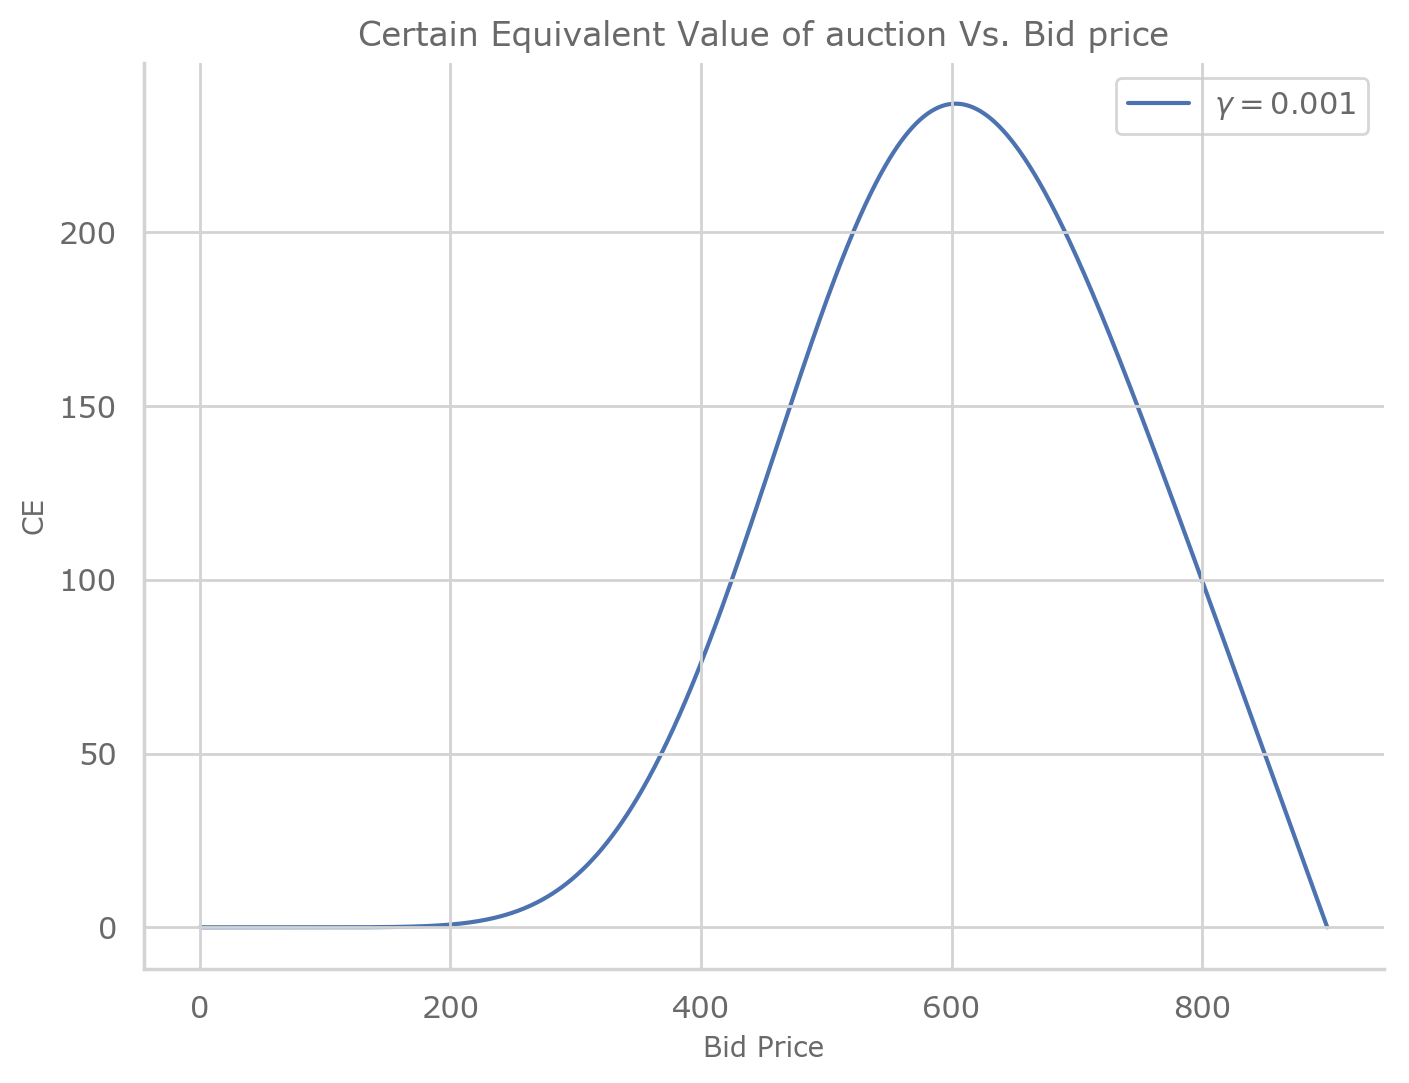

time: 293 ms (started: 2021-04-02 15:44:59 +08:00)


<IPython.core.display.Javascript object>

In [18]:
fig, ax = plt.subplots(1, 1)

ax.plot(
    bids,
    certainty_equivalent_values_calculator(
        u=partial(u, γ=np.array([γ]), a=0, b=1),
        u_inv=partial(u_inv, γ=np.array([γ]), a=0, b=1),
        x=np.vstack((pibp_net, np.zeros(pibp_net.shape))).T,
        p=np.vstack((p_acquire, 1 - p_acquire)).T,
        γ=np.array([γ]),
    )[0],
    label=r"$\gamma = 0.001$",
)
ax.set_xlabel("Bid Price")
ax.set_ylabel("CE")
ax.set_title(r"Certain Equivalent Value of auction Vs. Bid price")
plt.legend()
plt.show()

3)	Determine the least amount the decision maker needs to be paid in order to not participate in this bidding situation.

In [19]:
certainty_equivalent_auction_values = np.round(
    certainty_equivalent_values_calculator(
        u=partial(u, γ=0.001, a=0, b=1),
        u_inv=partial(u_inv, γ=0.001, a=0, b=1),
        x=np.vstack((pibp_net, np.zeros(pibp_net.shape))).T,
        p=np.vstack((p_acquire, 1 - p_acquire)).T,
        γ=0.001,
    )[0],
    2,
)

print(
    "The minimum amount the decision maker needs to be paid in order to not participate in the bidding is: ${}".format(
        np.min(
            certainty_equivalent_auction_values[
                np.nonzero(certainty_equivalent_auction_values)
            ]
        )
    )
)

The minimum amount the decision maker needs to be paid in order to not participate in the bidding is: $0.01
time: 15.8 ms (started: 2021-04-02 15:44:59 +08:00)


<IPython.core.display.Javascript object>

4)	Plot a sensitivity analysis for the optimal bid vs. the risk aversion coefficient.

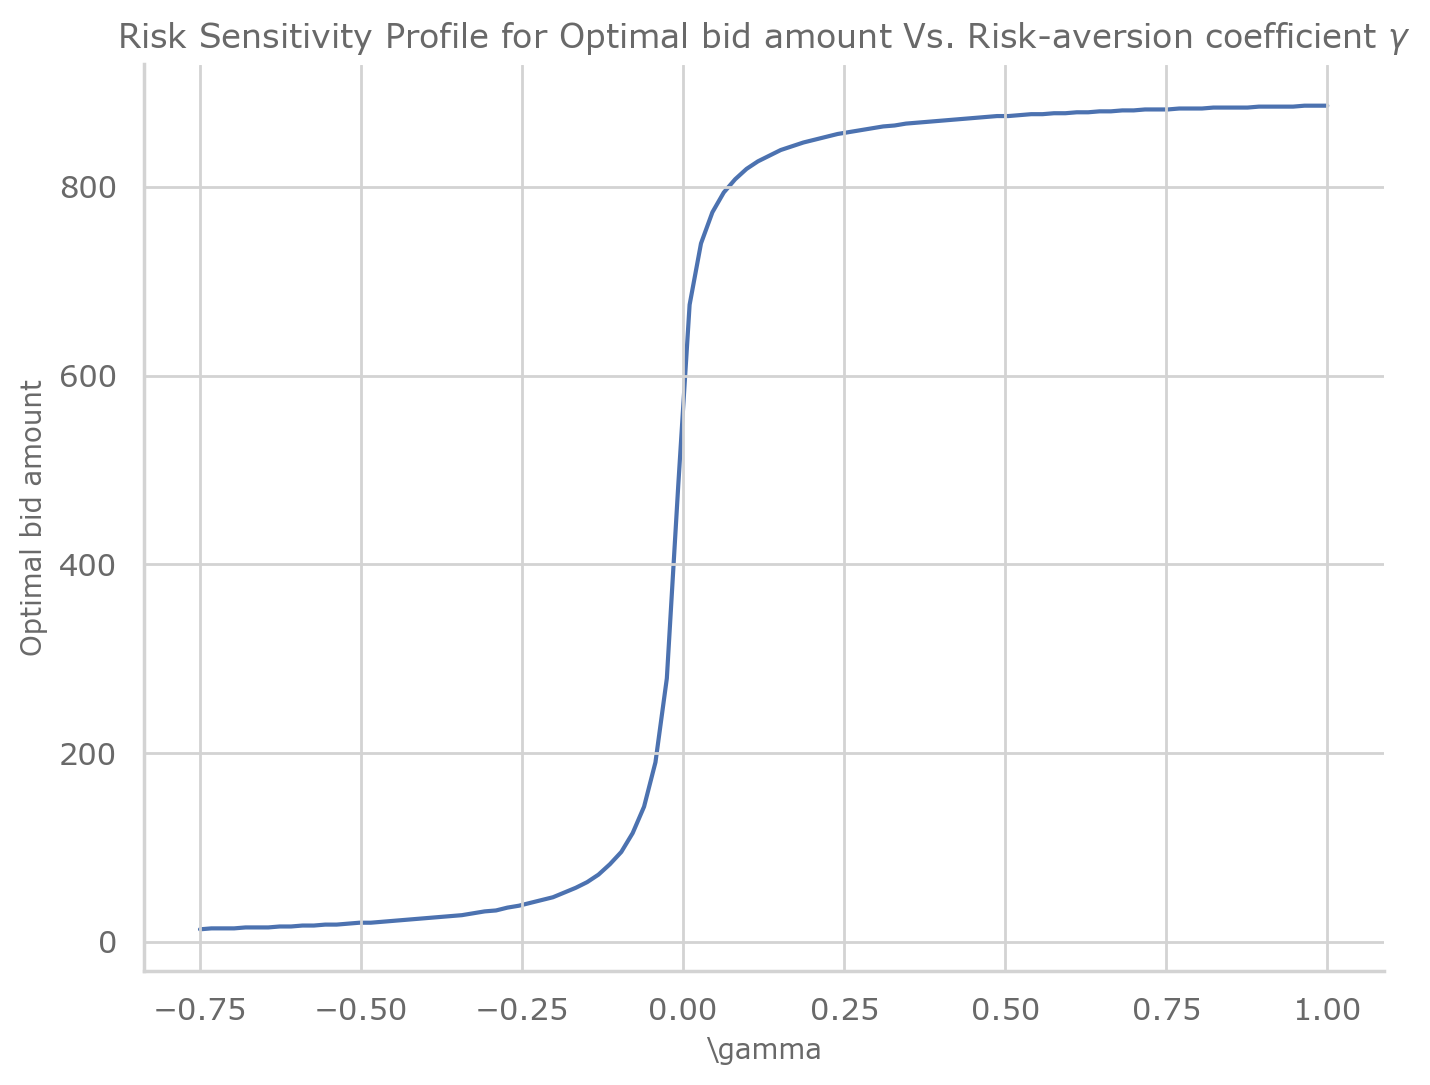

time: 1.13 s (started: 2021-04-02 15:44:59 +08:00)


<IPython.core.display.Javascript object>

In [20]:
fig, ax = plt.subplots(1, 1)

γ = np.linspace(-0.75, 1, num=100)

ax.plot(
    γ,
    [
        bids[optimal_bid_idx_for_γ]
        for optimal_bid_idx_for_γ in np.argmax(
            certainty_equivalent_values_calculator(
                u=partial(u, γ=γ, a=0, b=1),
                u_inv=partial(u_inv, γ=γ, a=0, b=1),
                x=np.vstack((pibp_net, np.zeros(pibp_net.shape))).T,
                p=np.vstack((p_acquire, 1 - p_acquire)).T,
                γ=γ,
            ),
            axis=1,
        )
    ],
)
ax.set_xlabel(r"\gamma")
ax.set_ylabel("Optimal bid amount")
ax.set_title(
    r"Risk Sensitivity Profile for Optimal bid amount Vs. Risk-aversion coefficient $\gamma$"
)
plt.show()

5)	Plot a sensitivity analysis for value of bidding situation vs the risk aversion coefficient.

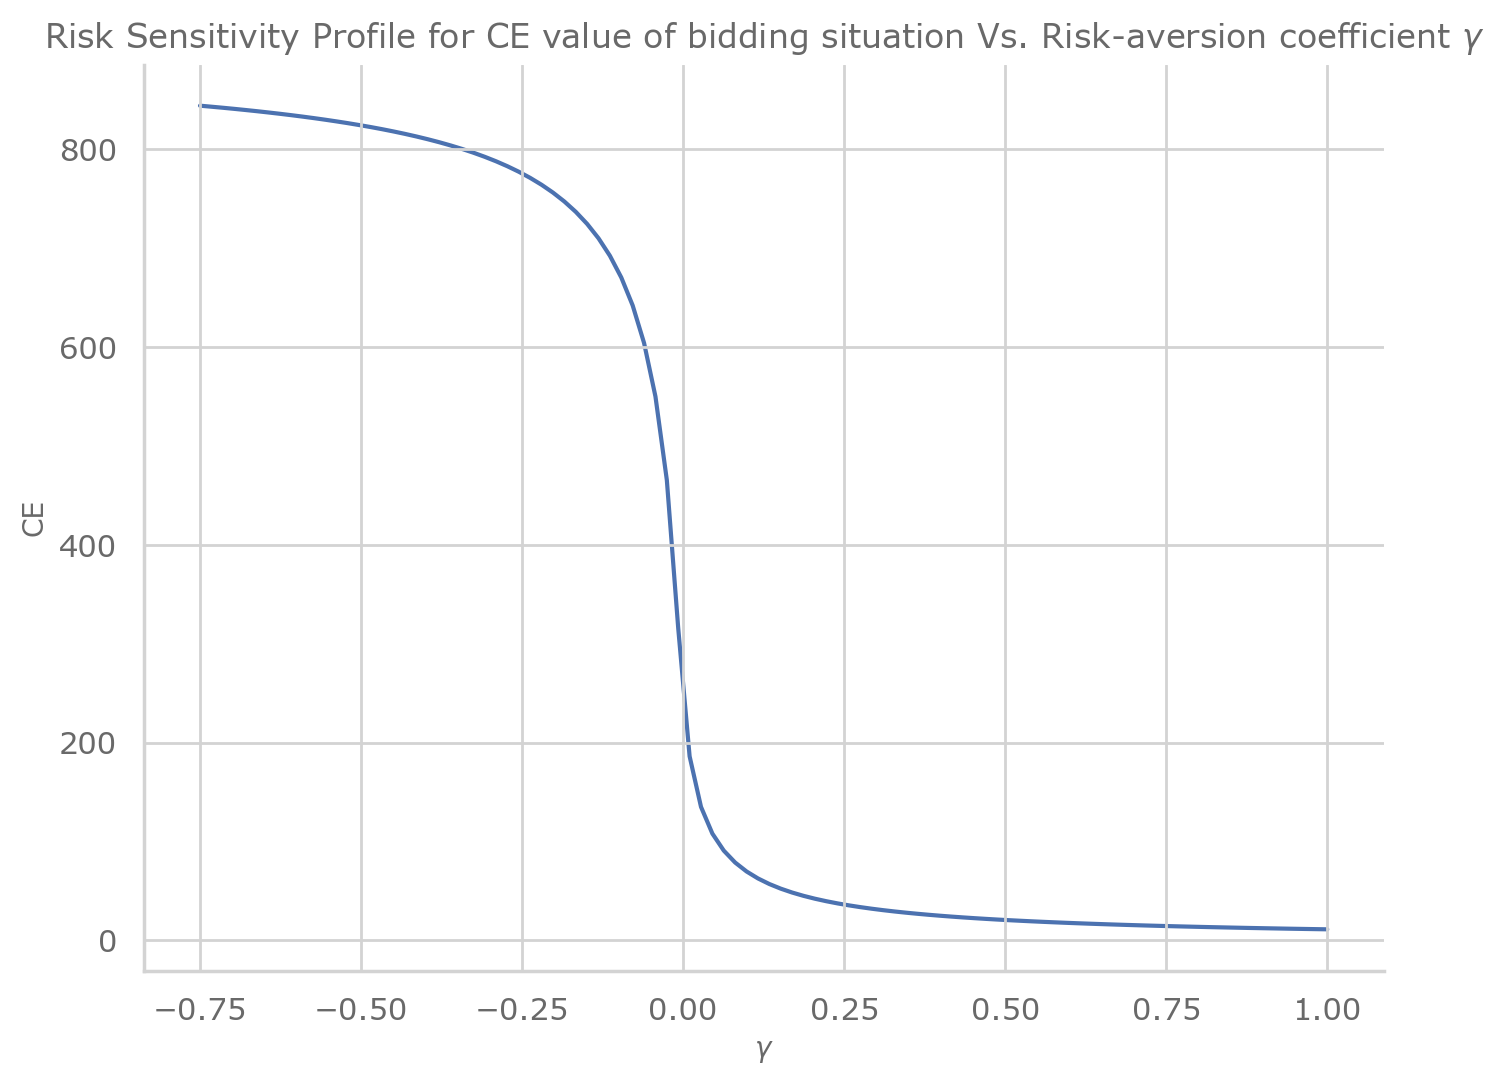

time: 997 ms (started: 2021-04-02 15:45:00 +08:00)


<IPython.core.display.Javascript object>

In [21]:
fig, ax = plt.subplots(1, 1)

γ = np.linspace(-0.75, 1, num=100)

ax.plot(
    γ,
    np.max(
        certainty_equivalent_values_calculator(
            u=partial(u, γ=γ, a=0, b=1),
            u_inv=partial(u_inv, γ=γ, a=0, b=1),
            x=np.vstack((pibp_net, np.zeros(pibp_net.shape))).T,
            p=np.vstack((p_acquire, 1 - p_acquire)).T,
            γ=γ,
        ),
        axis=1,
    ),
)
ax.set_xlabel(r"$\gamma$")
ax.set_ylabel("CE")
ax.set_title(
    "Risk Sensitivity Profile for CE value of bidding situation Vs. Risk-aversion coefficient $\gamma$"
)
plt.show()

6)	Extra Credit: Plot a two-way sensitivity analysis for optimal bid vs the two parameters (risk aversion coefficient and PIBP). This is a 3D plot.

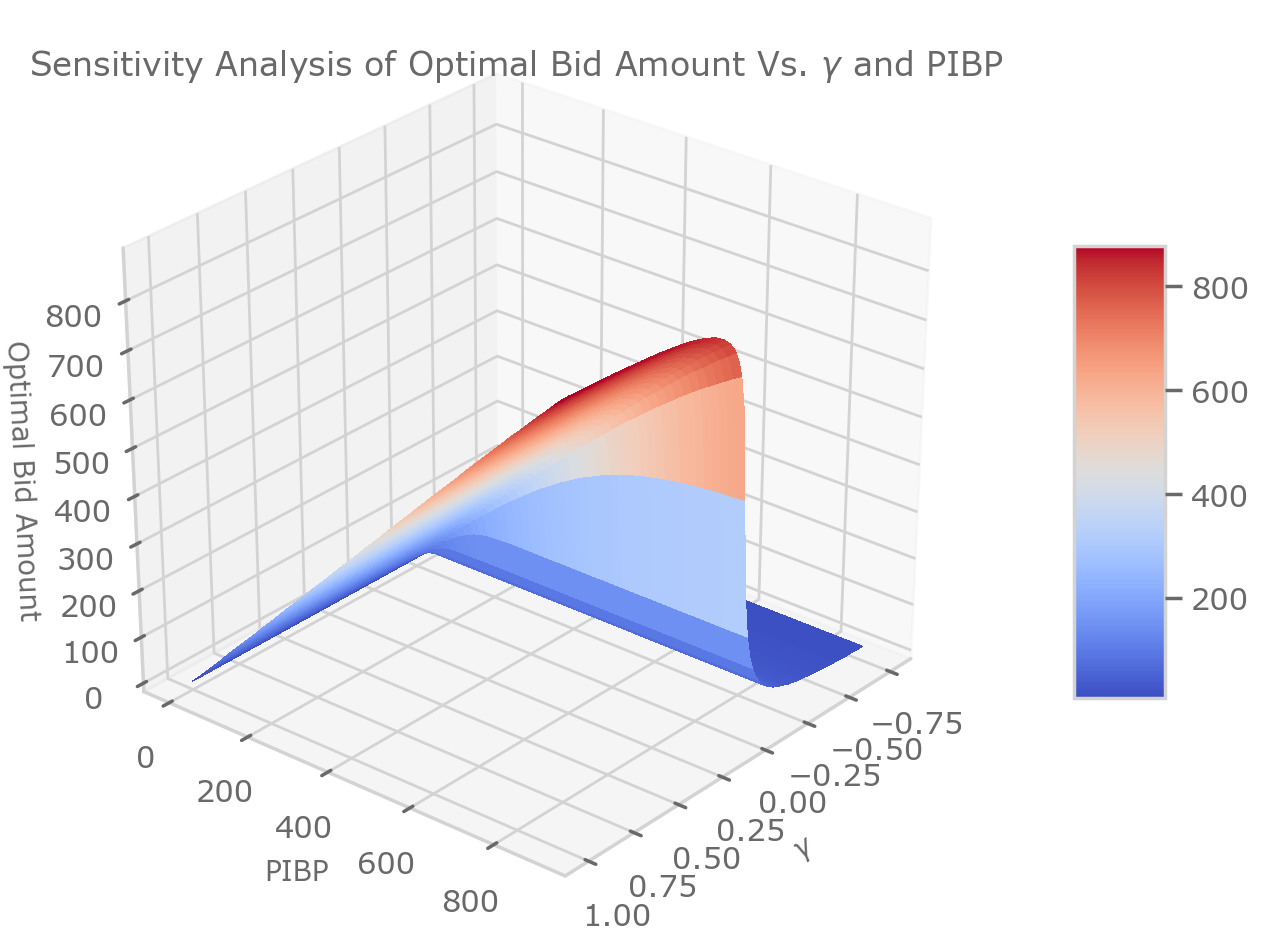

time: 39.2 s (started: 2021-04-02 15:45:01 +08:00)


<IPython.core.display.Javascript object>

In [22]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, colors
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

bids = np.array(list(range(900 + 1)))
p_acquire = np.array([sp.beta.cdf(x=rv, a=10, b=10, loc=0, scale=1000) for rv in bids])
γ = np.linspace(-0.75, 1, num=100)
pibp_values = np.linspace(0, 900 + 1)
X, Y = np.meshgrid(γ, pibp_values)
Z = np.array(
    [
        [
            bids[
                np.argmax(
                    certainty_equivalent_values_calculator(
                        u=partial(u, γ=γ_i, a=0, b=1),
                        u_inv=partial(u_inv, γ=γ_i, a=0, b=1),
                        x=np.vstack((pibp - bids, np.zeros(bids.shape))).T,
                        p=np.vstack((p_acquire, 1 - p_acquire)).T,
                        γ=γ_i,
                    ),
                    axis=1,
                )[0]
            ]
            for γ_i in γ
        ]
        for pibp in pibp_values
    ]
)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False,)
ax.view_init(30, 40)
ax.set_xlabel(r"$\gamma$")
ax.set_ylabel(r"PIBP")
ax.set_zlabel("Optimal Bid Amount")
ax.set_title("Sensitivity Analysis of Optimal Bid Amount Vs. $\gamma$ and PIBP")

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()